# DECISION  TREE CLASSIFIER ---------------------------------------------------------------------

### Get Train, Valid, Test data

In [1]:
import pandas as pd
from my_libs import lib_tools as pt

# run_type = 'dev'        # uncomment this line to have a quick execution
run_type = 'prd'          # uncomment this lone for normal execution
gen_sample = True         # True : execute SMOTEN resampling before DecisionTree - False : load previously "smoted" data from pickle file
find_best_params = False  # True : look for the best hyperparameters with Optuna (can be long)

# Get train, valid, and test sets
X_train, y_train, X_valid, y_valid, X_test, y_test = pt.get_train_valid_test_data(run_type)
print("Train, valid and Test data loaded")

Train, valid and Test data loaded


### Resample data with SMOTEN()

C:\Users\nicol\AppData\Roaming\Python\Python39\site-packages\imblearn\over_sampling\_smote\base.py:858: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


--- Smote applied in 231.9778618812561 seconds ---
Classes cardinality after resampling :
1    48850
0    48850
Name: grav, dtype: int64
X shape : (64000, 26) -> (97700, 26)
y shape : (64000,) -> (97700,)


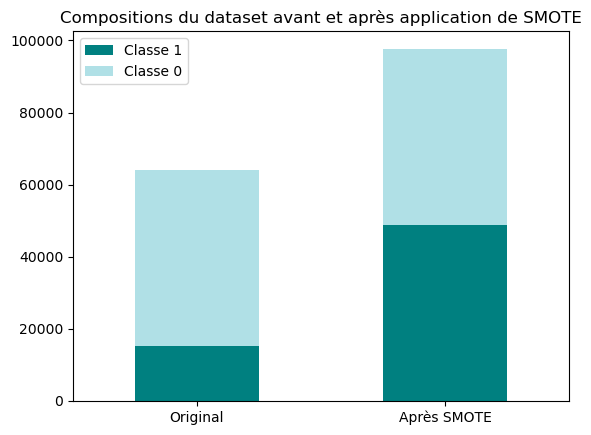

In [2]:
if gen_sample:
    X_train_rs, y_train_rs = pt.get_data_resampled(X=X_train, y=y_train, verbose=1)
    # Save data generated
    X_train_rs.to_pickle(f'./pickles/X_train_smote_{run_type}_dt_{X_train.shape[0]}.pkl')
    y_train_rs.to_pickle(f'./pickles/y_train_smote_{run_type}_dt_{X_train.shape[0]}.pkl')
else:
    # Load data previously generated
    X_train_rs = pd.read_pickle(f'./pickles/X_train_smote_{run_type}_dt_{X_train.shape[0]}.pkl')
    y_train_rs = pd.read_pickle(f'./pickles/y_train_smote_{run_type}_dt_{X_train.shape[0]}.pkl')

pt.plot_data_augmentation(y_train, y_train_rs)

### Encode categorical data (target and one hot encoding)

In [3]:
from my_libs.encoder_custom import  EncoderCustom

cols_target_encoded = ['dep']
cols_onehot_encoded = X_train.columns.drop(cols_target_encoded)

encoder = EncoderCustom(cols_target_encoded=cols_target_encoded, cols_onehot_encoded=cols_onehot_encoded)

X_train_rs_enc, y_train_rs_enc = encoder.transform(X=X_train_rs, y=y_train_rs, datatype='Train')
X_valid_enc, y_valid_enc = encoder.transform(X=X_valid, y=y_valid, datatype='Test')
X_test_enc, y_test_enc = encoder.transform(X=X_test , y=y_test , datatype='Test')

C:\Users\nicol\AppData\Roaming\Python\Python39\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\nicol\AppData\Roaming\Python\Python39\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


Columns target encoded : ['dep']
Columns one hot encoded : ['place', 'catu', 'sexe', 'trajet', 'locp', 'actp', 'etatp', 'mois', 'lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ', 'catv', 'age_cls', 'joursem']
--- Train set - features encoding performed in 6.20 seconds ---
--- Test set - features encoding performed in 0.45 seconds ---
--- Test set - features encoding performed in 0.52 seconds ---


### Find best hyperparameters for model with Optuna

In [4]:
import time
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

if find_best_params:

    n_trials = 10
    start_time = time.time()

    def objective(trial):

        dt_criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
        dt_splitter = trial.suggest_categorical('splitter', ['best', 'random'])
        dt_max_depth = trial.suggest_int('max_depth', 2, 20)
        dt_min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
        classifier_obj = DecisionTreeClassifier(criterion=dt_criterion, splitter=dt_splitter, max_depth=dt_max_depth, min_samples_split=dt_min_samples_split)

        score = cross_val_score(classifier_obj, X_train_rs_enc, y_train_rs_enc, cv=5, scoring="f1", verbose=1)
        accuracy = score.mean()

        return accuracy

    # Create a study object and optimize the objective function.
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print(f"\n--- Decision Tree Classifier - Optimization with Optuna performed in %s seconds ---" % (time.time() - start_time))
    print(f"Best params : {study.best_params}")
    
    from optuna.visualization import plot_optimization_history
    fig = plot_optimization_history(study)
    fig.show()

### Fit best model

In [5]:
if find_best_params:
    # model coming from optuna search
    params = study.best_params    
else:
    # train best model    
    criterion = 'gini'
    splitter = 'best'
    max_depth = 16
    min_samples_split = 11
    params = {'criterion': criterion, 'splitter': splitter, 'max_depth': max_depth, 'min_samples_split': 5}
    
model = DecisionTreeClassifier(**params)   
model.fit(X_train_rs_enc, y_train_rs_enc);

###  Plot Train and Test learning curves

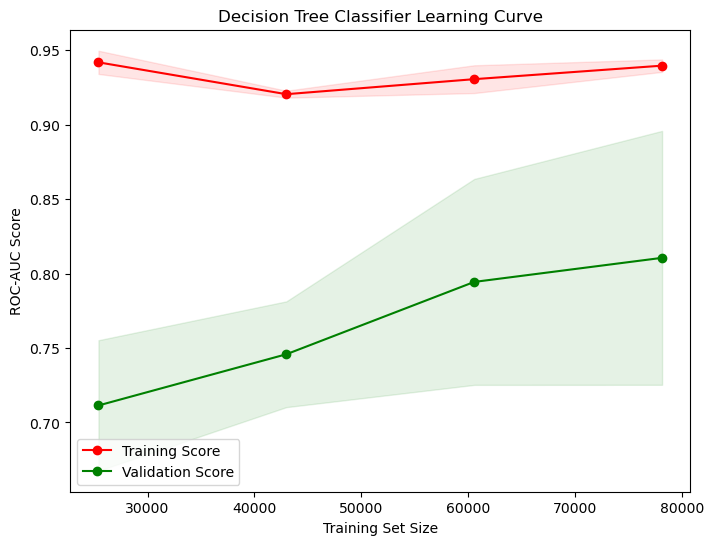

In [6]:
import numpy as np
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
%matplotlib inline

# Compute the learning curve
train_sizes, train_scores, valid_scores = learning_curve(model, X_train_rs_enc, y_train_rs_enc, cv=5, scoring='roc_auc', n_jobs=-1)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std  = np.std(valid_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 6))
plt.title('Decision Tree Classifier Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('ROC-AUC Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation Score')
plt.legend(loc='best')
plt.show()


### Confusion Matrix


In [7]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_enc)    
display(pd.crosstab(y_test_enc, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print("\nClassification report -------------------------------\n")
print(classification_report(y_test_enc, y_pred))

Classe prédite,0,1
Classe réelle,,
0,10719,5582
1,1308,2390



Classification report -------------------------------

              precision    recall  f1-score   support

           0       0.89      0.66      0.76     16301
           1       0.30      0.65      0.41      3698

    accuracy                           0.66     19999
   macro avg       0.60      0.65      0.58     19999
weighted avg       0.78      0.66      0.69     19999



### Plot ROC curves (from estimator & from predictions)

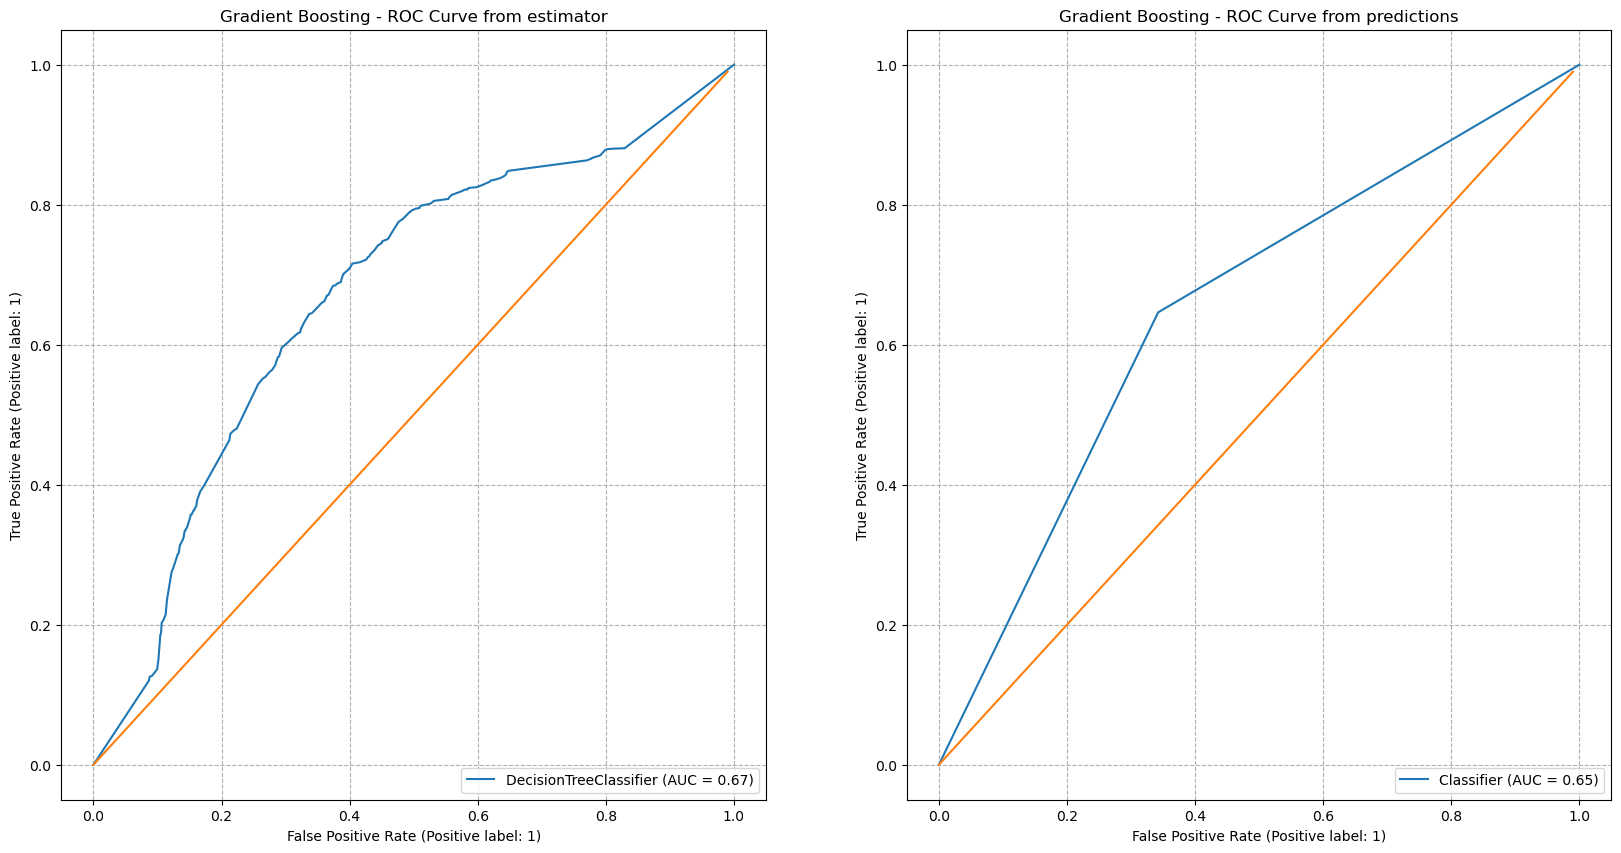

In [8]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2, figsize=(20,10))

RocCurveDisplay.from_estimator(model, X_test_enc, y_test_enc, ax=axs[0])
axs[0].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
axs[0].set_title('Gradient Boosting - ROC Curve from estimator')
axs[0].grid(linestyle='--')

RocCurveDisplay.from_predictions(y_test_enc, model.predict(X_test_enc), ax=axs[1])
axs[1].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
axs[1].set_title('Gradient Boosting - ROC Curve from predictions');
axs[1].grid(linestyle='--')

### Save model to h5

In [9]:
from joblib import dump
# Save the model to an h5 file using joblib
dump(model, f'h5_models/model_dt_{run_type}_{X_train.shape[0]}.h5')

['h5_models/model_dt_prd_64000.h5']